In [1]:
from aplpy import *
import pyfits
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature, io, filters, measure, color, exposure, segmentation, morphology
from skimage.filters import rank
from skimage.morphology import watershed, disk, reconstruction
from scipy import ndimage as ndi
from sklearn.cluster import k_means
from itertools import compress
import h5py
import datetime
%matplotlib inline

In [28]:
def normalise(inData):
    """
    Normalise array.
    """
    inDataAbs = np.fabs(inData)
    inDataMax = np.amax(inData)
    normalisedData = inDataAbs/inDataMax
    return normalisedData

def entropy(A):
    """
    Calculate Shannon entropy of array.
    """
    pA = A/A.sum()
    return -np.sum(pA*np.log2(A))

def cutArr(A):
    """
    Remove rows and columns of zero from input arr A.
    """
    A = A[:,~np.all(A == 0, axis=0)]
    A = A[~np.all(A == 0, axis=1)]
    return A

def onlyCell(inCell, p0, p1):
    """
    Return a mask that removes the background of a cell image.
    """
    pstart, pstop = np.percentile(inCell, (p0, p1))
    rescaledCell = exposure.rescale_intensity(inCell, in_range=(pstart, pstop))
    rescaledThresh = filters.threshold_otsu(rescaledCell)
    cellMask = rescaledCell <= rescaledThresh
    
    labelTmp = measure.label(cellMask, background=0)
    objTmp = ndi.find_objects(labelTmp)
    for i in np.arange(len(objTmp)): # A very hacky way to only mask areas on the edge of the cell
        if objTmp[i][0].start != 0 and objTmp[i][1].start !=0 and \
          objTmp[i][0].stop != inCell.shape[0] and objTmp[i][1].stop != inCell.shape[1]:
            cellMask[objTmp[i]] = False
    # It would be nice to mask the "cut off" parts of the cell too
    
    return cellMask

def genExample(cell):
    cell = cutArr(cell)
    
    vacuoles, mpeaks = getVacuholes(cell)
    vacuoleLabels = measure.label(mpeaks)
        
    return cell, np.ma.masked_array(cell, mpeaks), \
      vacuoleLabels

def getVacuholes(cell):
    """
    Get vacuoles using skimage.morphology.construction()
    """
    seed = np.copy(cell)
    seed[1:-1, 1:-1] = cell.max()
    mask = cell

    filled = reconstruction(seed, mask, method='erosion')

    thresh = filters.threshold_mean(filled-cell)
    mask = (filled-cell) >= thresh
    mask = morphology.remove_small_objects(mask, 100)
    labeled = measure.label(mask)

    vacuoles = ndi.find_objects(labeled)
    
    return np.array(filter(None,vacuoles)), mask

In [3]:
h5f = h5py.File("./data/cellImages50.h5", "r")
cellImages = h5f["cellImages"]

In [4]:
X_kmeans = k_means(np.reshape(cellImages,[-1,200*200]), 2, n_init=50) ## This looks like it works!!
unique, counts = np.unique(X_kmeans[1], return_counts=True)
print(dict(zip(unique, counts)))
blueCells = np.argmax(counts) # This is where the hole cells are likely to be
yellowCells = np.argmin(counts) # This is where the non-hole cells / noise are likely to be

{0: 180, 1: 1032}


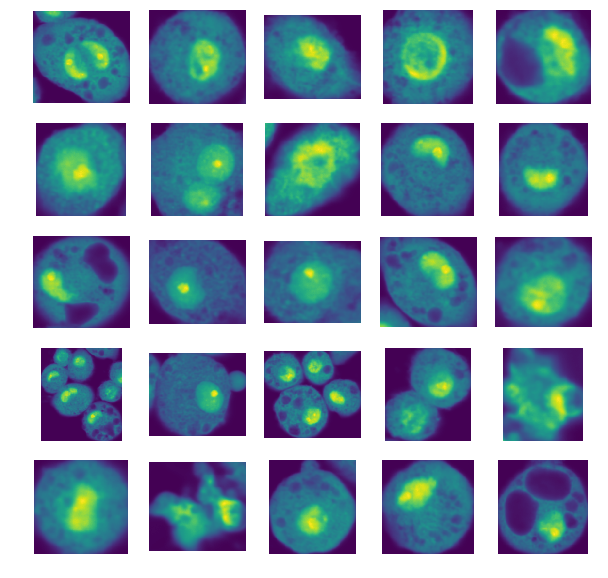

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
j = 0
for i in ax.ravel():
    i.imshow(cutArr(cellImages[np.where(X_kmeans[1] == blueCells)[0][j]]))
    j = j+1
    i.axis("off")

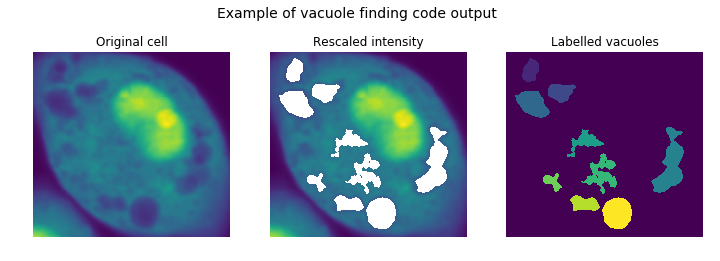

In [27]:
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

cell = cellImages[np.where(X_kmeans[1] == blueCells)[0][13]]
cell = cutArr(cell)

vacuoles, mpeaks = getVacuholes(cell)
vacuoleLabels = measure.label(mpeaks)

fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
for i in ax.ravel():
    i.axis("off")
ax[0].imshow(cell)
ax[0].set_title("Original cell")
ax[1].imshow(np.ma.masked_array(cell, mpeaks))
ax[1].set_title("Vacuoles removed")
ax[2].imshow(vacuoleLabels)
ax[2].set_title("Labelled vacuoles")
#ax[3].imshow(np.ma.masked_array(cell, vacuoleLabels != 0))
#ax[3].set_title("Found vacuoles removed")

plt.suptitle("Example of vacuole finding code output", fontsize=14)
#plt.savefig("./figures/output/"+dt+"_example.pdf")

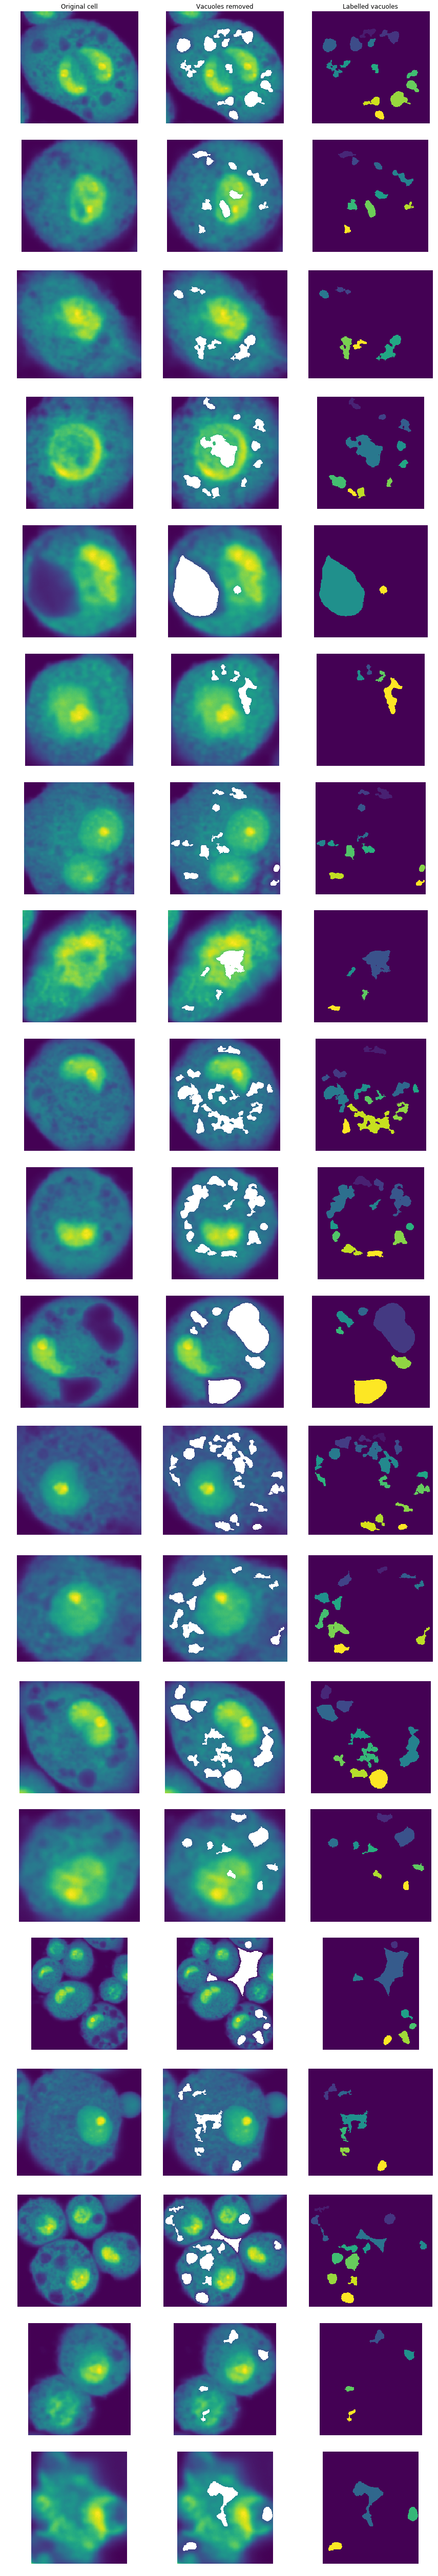

In [31]:
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

fig, ax = plt.subplots(ncols=3,nrows=20,figsize=(12,70))
for j in ax.ravel():
    j.axis("off")
ax[0,0].set_title("Original cell")  
ax[0,1].set_title("Vacuoles removed")
ax[0,2].set_title("Labelled vacuoles")
plt.tight_layout()

for i in np.arange(20):
    a,b,c = genExample(cellImages[np.where(X_kmeans[1] == blueCells)[0][i]])
    
    ax[i,0].imshow(a)
    ax[i,1].imshow(b)
    ax[i,2].imshow(c)
#plt.savefig("./figures/output/"+dt+"_example.pdf")